In [1]:
%reset -f
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gaitFunctions
import analyzeSteps
%whos

Variable        Type      Data/Info
-----------------------------------
analyzeSteps    module    <module 'analyzeSteps' fr<...>ub/gait/analyzeSteps.py'>
gaitFunctions   module    <module 'gaitFunctions' f<...>b/gait/gaitFunctions.py'>
np              module    <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os              module    <module 'os' (frozen)>
pd              module    <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt             module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns             module    <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


# update CSS in combined excel files

In [2]:
# update CSS in gait_speeds_df in combined excel files
excel_filename = 'control_v_disulfiram.xlsx'
gdf = pd.read_excel(excel_filename, sheet_name = 'gait_speeds', index_col=None)
print(gdf.columns)
print(len(gdf))
gdf.head(3)

Index(['frametimes', 'speed (mm/s)', 'speed (bodylength/s)', 'gaits_lateral',
       'swinging_lateral', 'gaits_rear', 'swinging_rear',
       'tetrapod_coordination', 'tetrapod_speed', 'tripod_coordination',
       'tripod_speed', 'clip', 'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')
45379


,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed,clip,treatment,individual,date,uniq_id
0,1.1775,0.033364,0.138781,stand,NaN,step,L4,NaN,NaN,NaN,NaN,iw_12Jan_control_tardigrade01_056-068,control,1,12jan,iw_12jan_tardigrade01_control
1,1.2077,0.035146,0.146191,pentapod,L1,step,L4,NaN,NaN,NaN,NaN,iw_12Jan_control_tardigrade01_056-068,control,1,12jan,iw_12jan_tardigrade01_control
2,1.2379,0.036848,0.153272,pentapod,L1,step,L4,NaN,NaN,NaN,NaN,iw_12Jan_control_tardigrade01_056-068,control,1,12jan,iw_12jan_tardigrade01_control


In [3]:
clips = gdf['clip'].values
done_clip = []

all_tet_css = np.empty(len(gdf))
all_tet_css[:] = np.nan
all_tet_speed = np.empty(len(gdf))
all_tet_speed[:] = np.nan
# print(all_tet_speed[:20])

all_tri_css = np.empty(len(gdf))
all_tri_css[:] = np.nan
all_tri_speed = np.empty(len(gdf))
all_tri_speed[:] = np.nan

for i, clip in enumerate(clips):
    if clip not in done_clip:
        # print(clip) # testing OK
        cdf = gdf[gdf['clip']==clip]
        tet_coord_strength_vec, tet_coord_speed_vec = analyzeSteps.getCssAndSpeeds(cdf, 'tetrapod')
        # print(tet_coord_speed_vec[:20]) # testing OK
        all_tet_css[i:i+len(tet_coord_strength_vec)] = tet_coord_strength_vec
        all_tet_speed[i:i+len(tet_coord_speed_vec)] = tet_coord_speed_vec
        
        tri_coord_strength_vec, tri_coord_speed_vec = analyzeSteps.getCssAndSpeeds(cdf, 'tripod')
        all_tri_css[i:i+len(tri_coord_strength_vec)] = tri_coord_strength_vec
        all_tri_speed[i:i+len(tri_coord_speed_vec)] = tri_coord_speed_vec
    
        done_clip.append(clip)

# testing
# for x in all_css[:100]:
#     print(x)

# print(len(all_tri_css))
# print(all_tet_speed[:20])

In [4]:
# put these into gdf
gdf['tetrapod_coordination'] = all_tet_css
gdf['tetrapod_speed'] = all_tet_speed

gdf['tripod_coordination'] = all_tri_css
gdf['tripod_speed'] = all_tri_speed

In [5]:
# and save
print('saving', excel_filename)
with pd.ExcelWriter(excel_filename, engine='openpyxl', if_sheet_exists='replace', mode='a') as writer: 
    gdf.to_excel(writer, index=False, sheet_name='gait_speeds')

saving control_v_disulfiram.xlsx


# update CSS in gait_summaries sheet via (new) data in gait_styles sheet

In [6]:
%reset -f
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gaitFunctions
import analyzeSteps
%whos

Variable        Type      Data/Info
-----------------------------------
analyzeSteps    module    <module 'analyzeSteps' fr<...>ub/gait/analyzeSteps.py'>
gaitFunctions   module    <module 'gaitFunctions' f<...>b/gait/gaitFunctions.py'>
np              module    <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os              module    <module 'os' (frozen)>
pd              module    <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt             module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns             module    <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


In [7]:
# load dataframes
excel_filename = 'control_v_disulfiram.xlsx'
gdf = pd.read_excel(excel_filename, sheet_name = 'gait_speeds', index_col=None)
gsdf = pd.read_excel(excel_filename, sheet_name = 'gait_summaries', index_col=None)
# print(gsdf.columns)
print(len(gsdf))
gsdf.head(3)

62


,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR pentapod (lateral legs),CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs)
0,iw_12jan_tardigrade01_control,control,tardigrade01,12jan,360,9.166667,45.00000,29.444444,10.833333,3.611111,...,0.140929,-0.063348,0.985427,0.747022,-2.264595,0.926511,-0.998702,0.267377,0.013954,-1.215488
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,12jan,363,11.019284,42.14876,36.363636,7.988981,2.203857,...,0.075472,0.147716,0.680862,0.253215,-2.264595,-1.027698,-0.998702,-0.208519,0.113211,-0.664172
2,iw_12jan_tardigrade02_control,control,tardigrade02,12jan,640,11.718750,50.62500,26.875000,7.968750,1.406250,...,0.258713,-0.154657,0.678326,-0.196067,2.185382,0.014674,-0.998702,0.541030,-0.095536,-0.779252


In [8]:
def meanNanRobust(vec):
    if np.isnan(vec).all():
        #print('all nan')
        #print(vec)
        return np.nan
    else:
        # print('did nanmean')
        return np.nanmean(vec)

def updateCSS(gait_speeds_df, gait_summaries_df):
    
    new_gaitspeeds_df = gait_speeds_df.copy()
    new_summaries_df = gait_summaries_df.copy()
    
    individuals = np.unique(gait_speeds_df['uniq_id'].values)
    tet_css = {}
    tet_boutspeed = {}
    tri_css = {}
    tri_boutspeed = {}

    for individual in individuals:
        ind_df = gait_speeds_df[gait_speeds_df['uniq_id']==individual]
        #print(individual, ind_df['tetrapod_coordination'].values[:20])

        tet_avg_css = meanNanRobust(ind_df['tetrapod_coordination'].values)
        tet_avg_boutspeed = meanNanRobust(ind_df['tetrapod_speed'].values)

        tet_css[individual] = tet_avg_css
        tet_boutspeed[individual] = tet_avg_boutspeed

        tri_avg_css = meanNanRobust(ind_df['tripod_coordination'].values)
        tri_avg_boutspeed = meanNanRobust(ind_df['tripod_speed'].values)
            
        tri_css[individual] = tri_avg_css
        tri_boutspeed[individual] = tri_avg_boutspeed
        
    summaries_individuals = new_summaries_df.Identifier.values
    
    tet_updated_css = [tet_css[individual] for individual in summaries_individuals]
    tet_updated_boutspeed = [tet_boutspeed[individual] for individual in summaries_individuals]
    
    tri_updated_css = [tri_css[individual] for individual in summaries_individuals]
    tri_updated_boutspeed = [tri_boutspeed[individual] for individual in summaries_individuals]
    
    new_summaries_df['Tetrapod Coordination Strength'] = tet_updated_css
    new_summaries_df['Tetrapod Bout Speed (bodylength / s)'] = tet_updated_boutspeed
    new_summaries_df['Tripod Coordination Strength'] = tri_updated_css
    new_summaries_df['Tripod Bout Speed (bodylength / s)'] = tri_updated_boutspeed
    
    return new_summaries_df

In [9]:
new_gsdf = updateCSS(gdf, gsdf)
print(gsdf['Tetrapod Coordination Strength'].values[:20])
print(new_gsdf['Tetrapod Coordination Strength'].values[:20])

[0.37523495 0.44352906 0.40416201 0.30845143 0.43634669 0.33779573
 0.36471428 0.32338289 0.53017818 0.57146285 0.35807288 0.62018414
 0.41064286 0.38404298 0.42405796 0.45759936 0.289194   0.40157815
 0.40713542 0.45447228]
[0.36915331 0.46591918 0.3827595  0.30679686 0.41540931 0.3092089
 0.33281494 0.29295669 0.48732346 0.6203065  0.38345246 0.51488095
 0.3805556  0.37520316 0.41463507 0.45667729 0.28877162 0.40237415
 0.39411963 0.45385167]


In [10]:
# and save
print('saving', excel_filename)
with pd.ExcelWriter(excel_filename, engine='openpyxl', if_sheet_exists='replace', mode='a') as writer: 
    new_gsdf.to_excel(writer, index=False, sheet_name='gait_summaries')

saving control_v_disulfiram.xlsx


# Coordination consistency score
This is a per-tardigrade score
= swings in tetrapod / total swings (for each leg or all legs)

In [ ]:
# From all tardigrade spreadsheet (all_exemplaris_2024-07-29.xlsx, gait_speeds sheet):
#     get gait_speeds_df
#     get gait_summaries_df
excel_file = 'all_exemplaris_2024-07-29.xlsx'
gait_speeds_df = pd.read_excel(excel_file, sheet_name = 'gait_speeds', index_col=None)
gait_summaries_df = pd.read_excel(excel_file, sheet_name = 'gait_summaries', index_col=None)
print(gait_speeds_df.columns)
gait_speeds_df.head(2)

In [ ]:
print(gait_summaries_df.columns)
gait_summaries_df.head(3)

In [ ]:
ndf = gaitFunctions.coordinationComboConsistency(gait_speeds_df, gait_summaries_df, 'tetrapod')

In [ ]:
new_interesting_df = ndf[['% tetrapod canonical (lateral legs)',
                                   'Tetrapod Coordination Strength',
                                   'Tetrapod Bout Speed (bodylength / s)',
                                   'tetrapod_coordination_consistency']]
new_interesting_df.head(3)

In [ ]:
fig,ax = plt.subplots(1,1,dpi=300,figsize=(2.6,2.2))
ax = sns.heatmap(new_interesting_df.corr(), annot=True, cmap="seismic", vmax=1, vmin=-1)
labs = ['% Tetrapod\nCanonical','Tetrapod\nCSS',
        'Tetrapod\nBoutspeed','Tetrapod\nCCS']
ax.set_xticks([0.5,1.5,2.5,3.5],labs)
ax.set_yticks([0.5,1.5,2.5,3.5],labs)
plt.show()

Very high correlation between 'combo consistency' and % tetrapod
<br> High correlation between bout speed and combo consistency and % tetrapod
<br> BUT coordination strength is not correlated to any of the other measurements


In [ ]:
# add coordination consistency to gait_summaries_df

# Coordination strength score

In July 2024, Made CSS robust to changes in identities of swinging legs<br>
<br>
For example: <br>
L1R2 → L3R2 with a seamless transition is now one bout of tetrapod_canonical rather than two

Exported code to analyzeSteps.py on 29 July 2024 (this code in analyzeSteps is likely updated and more current now)
<br>
<br>
But from above, coordination strength score (CSS) is not correlated to any of the other measures of coordination.
<br> This is a bit concerning ... need to check that I am assigning correct CSS to correct individuals.

<br><br>To double check, start with gait_styles sheet, and reassign CSS (and bout speed) to individuals.
<br><br>Update = same answers

# % tetrapod or tripod canonical vs. Coordination Strength

In [10]:
%reset -f
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import gaitFunctions
import analyzeSteps
excel_filename = 'all_exemplaris_2024-07-29.xlsx'
# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'
%whos

Variable         Type      Data/Info
------------------------------------
analyzeSteps     module    <module 'analyzeSteps' fr<...>ub/gait/analyzeSteps.py'>
excel_filename   str       all_exemplaris_2024-07-29.xlsx
gaitFunctions    module    <module 'gaitFunctions' f<...>b/gait/gaitFunctions.py'>
marker_alpha     float     0.4
marker_color     str       k
marker_size      int       10
np               module    <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os               module    <module 'os' (frozen)>
pd               module    <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt              module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns              module    <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
stats            module    <module 'scipy.stats' fro<...>scipy/stats/__init__.py'>


Tetrapod points 102
Tripod points   40
Tetrapod ρ = 0.12 p = 0.23
Tripod   ρ = 0.44 p = 0.0


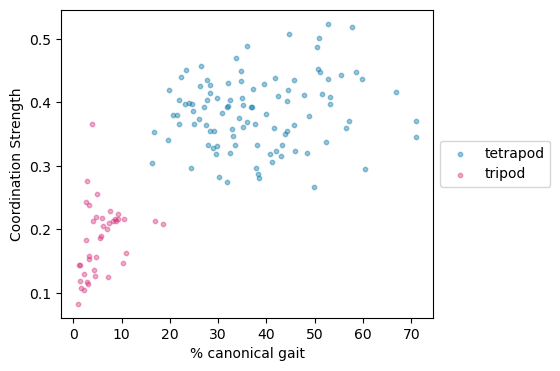

In [12]:
# in gait_summaries we have % tetrapod or tripod canonical for each individual
# in gait_summaries we also have tetrapod and tripod coordination strength
# make scatter plot of these
# should only include individuals where coordination strength score is based on > threshold number of bouts

# First we will get # of bouts per tardigrade ... 
# can get this info from gait_speeds sheet
gait_speeds_df = pd.read_excel(excel_filename, sheet_name='gait_speeds', index_col=None)

individuals = np.unique(gait_speeds_df['uniq_id'].values)
num_tetrapod_bouts = np.zeros(len(individuals))
num_tripod_bouts = np.zeros(len(individuals))
for i, individual in enumerate(individuals):
    tet_bouts = gait_speeds_df[gait_speeds_df.uniq_id == individual]['tetrapod_coordination'].values
    tet_bouts = gaitFunctions.omitNan(tet_bouts)
    # print(individual, len(tet_bouts)) # testing OK, all have at least 15 bouts
    num_tetrapod_bouts[i] = len(tet_bouts)
    
    tri_bouts = gait_speeds_df[gait_speeds_df.uniq_id == individual]['tripod_coordination'].values
    tri_bouts = gaitFunctions.omitNan(tri_bouts)
    # print(individual, len(tri_bouts)) # testing OK ... only 31 have at least 5 bouts; 63 have at least 2
    num_tripod_bouts[i] = len(tri_bouts)
    
tet_boutnum_dict = dict(zip(individuals, num_tetrapod_bouts))
tri_boutnum_dict = dict(zip(individuals, num_tripod_bouts))

# Next, we will get percentages of frames in canonical tetrapod or tripod 
gait_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)
# print(gait_df.columns)
identifiers = gait_df['Identifier'].values
tet_css_dict = dict(zip(identifiers, gait_df['Tetrapod Coordination Strength'].values))
tri_css_dict = dict(zip(identifiers, gait_df['Tripod Coordination Strength'].values))
tet_perc_dict = dict(zip(identifiers, gait_df['% tetrapod canonical (lateral legs)'].values))
tri_perc_dict = dict(zip(identifiers, gait_df['% tripod canonical (lateral legs)'].values))

# define minimum threshold number of bouts to consider
tet_threshold = 15 # all 103 tardigrades have more than 15 bouts of canonical tetrapod
tri_threshold = 5 # 31 tardigrades have 5 or more bouts of canonical tripod; 63 have 2 or more

# tetrapod scatter data
tet_perc = [tet_perc_dict[x] for x in identifiers if tet_boutnum_dict[x] >= tet_threshold]
tet_css = [tet_css_dict[x] for x in identifiers if tet_boutnum_dict[x] >= tet_threshold]

# tripod scatter data
tri_perc = [tri_perc_dict[x] for x in identifiers if tri_boutnum_dict[x] >= tri_threshold]
tri_css = [tri_css_dict[x] for x in identifiers if tri_boutnum_dict[x] >= tri_threshold]

# report number of points plotted
print('Tetrapod points', len(tet_perc))
print('Tripod points  ', len(tri_perc))

# get plot colors
combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

# setup figure and plot
f,a = plt.subplots(1,1,figsize=(6,4))

a.scatter(tet_perc,tet_css,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_perc,tri_css,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')

a.set_xlabel('% canonical gait')
a.set_ylabel('Coordination Strength')

# add a legend to right of axis
# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# run and report some statistics
tet_r,tet_p = stats.spearmanr(tet_perc,tet_css)
tri_r,tri_p = stats.spearmanr(tri_perc,tri_css)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()

# Bout Speed vs. Coordination Strength

Tetrapod ρ = -0.16 p = 0.11
Tripod   ρ = 0.03 p = 0.81


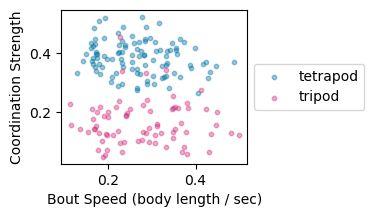

In [14]:
gait_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)

f,a = plt.subplots(1,1,figsize=(3,2))

tet_bs = gait_df['Tetrapod Bout Speed (bodylength / s)'].values
tet_cs = gait_df['Tetrapod Coordination Strength'].values
tri_bs = gait_df['Tripod Bout Speed (bodylength / s)'].values
tri_cs = gait_df['Tripod Coordination Strength'].values
tri_bs = tri_bs[np.where(~np.isnan(tri_bs))]
tri_cs = tri_cs[np.where(~np.isnan(tri_bs))]
tri_bs = tri_bs[np.where(~np.isnan(tri_cs))]
tri_cs = tri_cs[np.where(~np.isnan(tri_cs))]

combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

a.scatter(tet_bs,tet_cs,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_bs,tri_cs,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
a.set_xlabel('Bout Speed (body length / sec)')
a.set_ylabel('Coordination Strength')

# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

tet_r,tet_p = stats.spearmanr(tet_bs,tet_cs)
tri_r,tri_p = stats.spearmanr(tri_bs,tri_cs)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()

# Bout Speed vs. % tetrapod or tripod canonical

Tetrapod ρ = 0.71 p = 0.0
Tripod   ρ = -0.04 p = 0.68


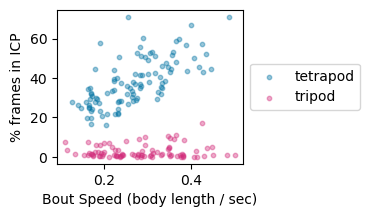

In [16]:
gait_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)

f,a = plt.subplots(1,1,figsize=(3,2))

tet_boutspeed = gait_df['Tetrapod Bout Speed (bodylength / s)'].values
tet_perc_can = gait_df['% tetrapod canonical (lateral legs)'].values
tri_boutspeed = gait_df['Tripod Bout Speed (bodylength / s)'].values
tri_perc_can = gait_df['% tripod canonical (lateral legs)'].values
tri_boutspeed = tri_boutspeed[np.where(~np.isnan(tri_boutspeed))]
tri_perc_can = tri_perc_can[np.where(~np.isnan(tri_boutspeed))]

combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

a.scatter(tet_boutspeed,tet_perc_can,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_boutspeed,tri_perc_can,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
a.set_xlabel('Bout Speed (body length / sec)')
a.set_ylabel('% frames in ICP')

# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

tet_r,tet_p = stats.spearmanr(tet_boutspeed,tet_perc_can)
tri_r,tri_p = stats.spearmanr(tri_boutspeed,tri_perc_can)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()


# first stab at coordination consistency, 28 July 2024

In [ ]:
## older version of coordination consistency (new version is now in gaitFunctions)
# old version here just calculated proportion of strides spent in *any* canonical ICP for each leg
# new version = calculated proportaion of strides spent in a *specific* (most common) ICP for each leg
# def coordinationConsistency(gait_speeds_df, gait_summaries_df, icp):  # 'tetrapod' or 'tripod'
    
#     coord_consistency_dict = {}
#     legs = ['L3','L2','L1','R3','R2','R1']
#     individuals = np.unique(gait_speeds_df['uniq_id'].values)
#     # print(len(individuals)) # testing OK

#     icp_searchterm = icp + '_canonical'

#     # For each individual
#     for individual in individuals:

#         # make df for this individual from gait_speeds_df
#         ind_df = gait_speeds_df[gait_speeds_df['uniq_id']==individual]
#         # print(len(ind_df)) # testing OK

#         total_swings = 0
#         swings_with_icp = 0

#         swinging_legs = ind_df['swinging_lateral'].values
#         icps = ind_df['gaits_lateral'].values
#         # print(swinging_legs) # testing OK

#         # For each leg
#         for leg in legs:

#             # make vector of 1's (swings for this leg) and 0's from swinging_lateral column
#             swings_for_this_leg = np.zeros(len(swinging_legs))
#             for i, swing in enumerate(swinging_legs):
#                 try:
#                     if leg in swing:
#                         swings_for_this_leg[i] = 1
#                 except:
#                     swings_for_this_leg[i] = 0

#             # print(leg, swings_for_this_leg) # testing OK

#             # From this vector, get num_swings (aka number of 1 runs)
#             swings = gaitFunctions.one_runs(swings_for_this_leg)
#             # print(leg, len(swings), swings) # testing OK

#             total_swings += len(swings)

#             # For each swing
#             for swing in swings:
#                 # get each swing start through swing end
#                 swing_start = swing[0]
#                 swing_end = swing[1]

#                 # Check vector of gaits_lateral within this interval ... is there tetrapod_canonical?
#                 if icp_searchterm in icps[swing_start:swing_end]:
#                     # print(icp_searchterm, icps[swing_start:swing_end]) # testing OK
#                     # if yes, add 1 to swings_with_icp
#                     swings_with_icp += 1

#         # Finished collecting legs for this invididual
#         # Calculate coord_consistency (swings_with_icp / total_swings)
#         coord_consistency = swings_with_icp / total_swings
#         # print(individual, coord_consistency) # testing OK
#         coord_consistency_dict[individual] = coord_consistency
    
#     # add this dictionary as a column to gait_summaries df
#     new_df = gait_summaries_df.copy()
#     new_individuals = new_df.Identifier.values
#     cc = [coord_consistency_dict[i] for i in new_individuals]
#     # print(cc) # testing OK
#     new_df[icp + '_coordination_consistency'] = cc
    
#     return new_df

# gait_summaries_df = coordinationConsistency(gait_speeds_df, gait_summaries_df, 'tetrapod')
# # gait_summaries_df.head(3)

# # then do some paired comparisons:
# # • speed vs. coord_consistency
# # • % tetrapod_canonical vs. coord_consistency
# # • coordination strength score vs. coord_consistency

# # Or better, a correlation matrix including:
# #     speed
# #     coordination %
# #     coordination strength
# #     coordination consistency